# Importing Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 142640498.04it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 29466235.42it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34410501.42it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 27176217.93it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


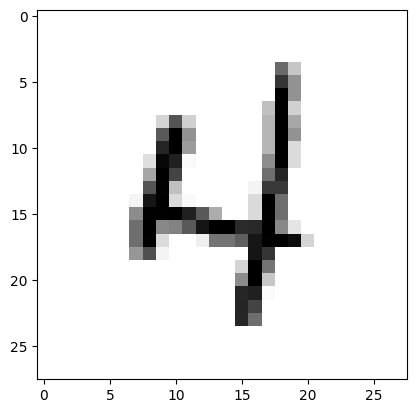

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

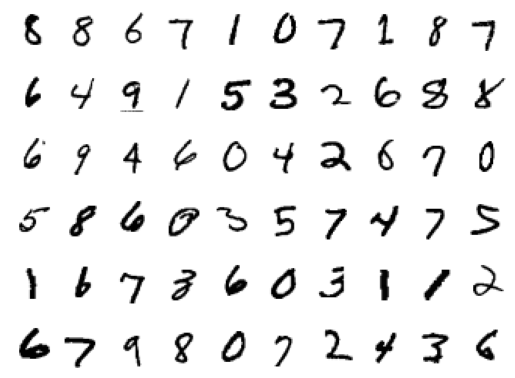

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The Model

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),

            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),

            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),


            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),


            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             900
              ReLU-4           [-1, 10, 24, 24]               0
            Conv2d-5           [-1, 20, 22, 22]           1,800
              ReLU-6           [-1, 20, 22, 22]               0
         MaxPool2d-7           [-1, 20, 11, 11]               0
            Conv2d-8           [-1, 10, 11, 11]             200
              ReLU-9           [-1, 10, 11, 11]               0
           Conv2d-10             [-1, 10, 9, 9]             900
             ReLU-11             [-1, 10, 9, 9]               0
           Conv2d-12             [-1, 20, 7, 7]           1,800

# Training and Testing

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.33772167563438416 Batch_id=468 Accuracy=54.15: 100%|██████████| 469/469 [00:18<00:00, 25.37it/s]



Test set: Average loss: 0.2250, Accuracy: 9276/10000 (92.76%)

EPOCH: 1


Loss=0.16647852957248688 Batch_id=468 Accuracy=94.71: 100%|██████████| 469/469 [00:18<00:00, 25.66it/s]



Test set: Average loss: 0.1187, Accuracy: 9647/10000 (96.47%)

EPOCH: 2


Loss=0.10009205341339111 Batch_id=468 Accuracy=96.58: 100%|██████████| 469/469 [00:17<00:00, 26.41it/s]



Test set: Average loss: 0.0708, Accuracy: 9763/10000 (97.63%)

EPOCH: 3


Loss=0.06489933282136917 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:17<00:00, 27.22it/s]



Test set: Average loss: 0.0636, Accuracy: 9797/10000 (97.97%)

EPOCH: 4


Loss=0.030304016545414925 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:18<00:00, 25.73it/s]



Test set: Average loss: 0.0536, Accuracy: 9821/10000 (98.21%)

EPOCH: 5


Loss=0.08869908004999161 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:16<00:00, 28.02it/s]



Test set: Average loss: 0.0514, Accuracy: 9822/10000 (98.22%)

EPOCH: 6


Loss=0.056231770664453506 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:16<00:00, 27.73it/s]



Test set: Average loss: 0.0502, Accuracy: 9810/10000 (98.10%)

EPOCH: 7


Loss=0.025984445586800575 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:17<00:00, 27.38it/s]



Test set: Average loss: 0.0481, Accuracy: 9840/10000 (98.40%)

EPOCH: 8


Loss=0.035508204251527786 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:17<00:00, 27.25it/s]



Test set: Average loss: 0.0525, Accuracy: 9814/10000 (98.14%)

EPOCH: 9


Loss=0.018023643642663956 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:18<00:00, 25.97it/s]



Test set: Average loss: 0.0435, Accuracy: 9856/10000 (98.56%)

EPOCH: 10


Loss=0.04249094799160957 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:17<00:00, 27.15it/s]



Test set: Average loss: 0.0366, Accuracy: 9883/10000 (98.83%)

EPOCH: 11


Loss=0.0727001205086708 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:18<00:00, 25.71it/s]



Test set: Average loss: 0.0390, Accuracy: 9867/10000 (98.67%)

EPOCH: 12


Loss=0.03799734264612198 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:17<00:00, 27.08it/s]



Test set: Average loss: 0.0430, Accuracy: 9869/10000 (98.69%)

EPOCH: 13


Loss=0.02909659780561924 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:18<00:00, 25.29it/s]



Test set: Average loss: 0.0361, Accuracy: 9885/10000 (98.85%)

EPOCH: 14


Loss=0.012262548319995403 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 27.19it/s]



Test set: Average loss: 0.0345, Accuracy: 9877/10000 (98.77%)

EPOCH: 15


Loss=0.015999125316739082 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:18<00:00, 25.68it/s]



Test set: Average loss: 0.0368, Accuracy: 9890/10000 (98.90%)

EPOCH: 16


Loss=0.011690107174217701 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:19<00:00, 23.98it/s]



Test set: Average loss: 0.0353, Accuracy: 9885/10000 (98.85%)

EPOCH: 17


Loss=0.004575600381940603 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 25.46it/s]



Test set: Average loss: 0.0370, Accuracy: 9888/10000 (98.88%)

EPOCH: 18


Loss=0.007124684285372496 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 27.17it/s]



Test set: Average loss: 0.0393, Accuracy: 9880/10000 (98.80%)

EPOCH: 19


Loss=0.0022815868724137545 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:19<00:00, 24.43it/s]



Test set: Average loss: 0.0341, Accuracy: 9890/10000 (98.90%)



Text(0.5, 1.0, 'Test Accuracy')

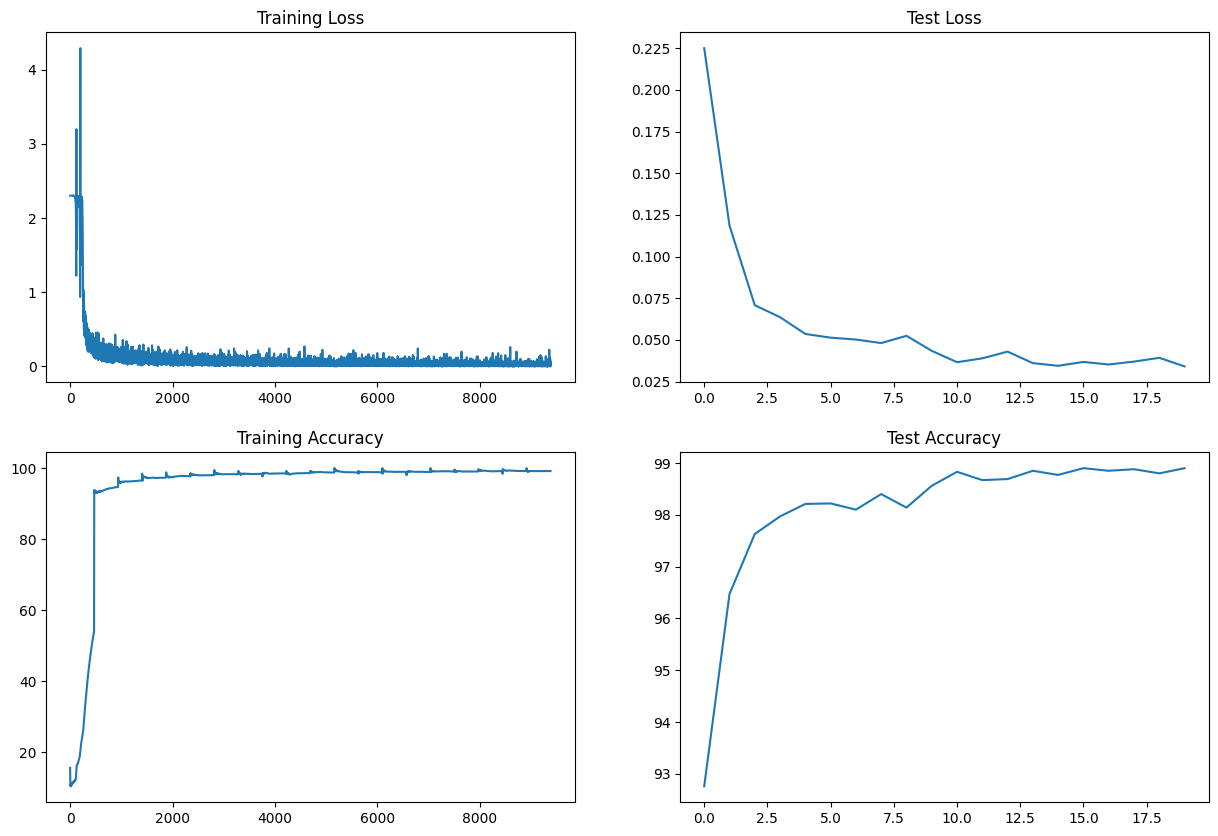

In [11]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target
  1. Make the model lighter
## Result
  1. Parameters is 10.7k
  2. Our Best Train accuracy is 99.19%
  3. Out Best Test accuracy is 98.90%
# Analysis
  1. Model is pretty good
  2. Gives fair good accuracy even when it is a lighter model